# Training in mini-batches

## Why minibatch vs batch gradient descent?

The goal is to get better generalization, smaller validation loss. We want batch size to be as large as possible for efficiency on GPUs, but as small as possible to get the stochastic bouncing around down into lower minima.

* [Tradeoff batch size vs. number of iterations to train a neural network](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network)
* [Why mini batch size is better than one single “batch” with all training data?](https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data)
* [Revisiting Small Batch Training for Deep Neural Networks](https://arxiv.org/abs/1804.07612)

In [60]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [61]:
def plot_history(history, ax=None, maxy=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    accur = history[:,0]
    val_accur = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_accur))
    ax.plot(accur, label='train_loss')
    ax.plot(val_accur, label='val_loss')
    ax.legend(loc='upper right')

In [62]:
d = load_diabetes()
len(d.data)

442

In [63]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [64]:
n = len(df)
n_test = int(n*0.20)
n_train = n - n_test
df = df.sample(frac=1) # shuffle data
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [65]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

In [66]:
rf = RandomForestRegressor(n_estimators=500, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 1197.59 validation MSE 3112.00


In [67]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## Minibatch stochastic gradient descent (SGD)

In [68]:
def sgdtrain(model, X_train, X_test, y_train, y_test,
             learning_rate = .5, nepochs=2000, weight_decay=0, batch_size=32,
             trace=True):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    history = []
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            loss = 0
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            loss = torch.mean((y_pred - batch_y)**2)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()
        
        epoch_training_loss /= nbatches # average batch loss

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((epoch_training_loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
        
        if trace and epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {epoch_training_loss:12.3f}   test loss {loss_test:12.3f}")

    print(f"BEST MSE test loss {best_loss:.3f}")
    return torch.tensor(history), best_model

Epoch    0 MSE train loss    30907.368   test loss    23507.633
Epoch   10 MSE train loss     3133.388   test loss     3116.233
Epoch   20 MSE train loss     2963.070   test loss     3205.002
Epoch   30 MSE train loss     2636.353   test loss     3068.198
Epoch   40 MSE train loss     2582.945   test loss     3184.005
Epoch   50 MSE train loss     3573.986   test loss     3034.060
Epoch   60 MSE train loss     2222.330   test loss     3276.662
Epoch   70 MSE train loss     1917.307   test loss     3342.359
Epoch   80 MSE train loss     1741.688   test loss     3588.754
Epoch   90 MSE train loss     1676.930   test loss     3754.252
Epoch  100 MSE train loss     1527.513   test loss     3768.554
BEST MSE test loss 3034.060
MSE test loss 3034.060


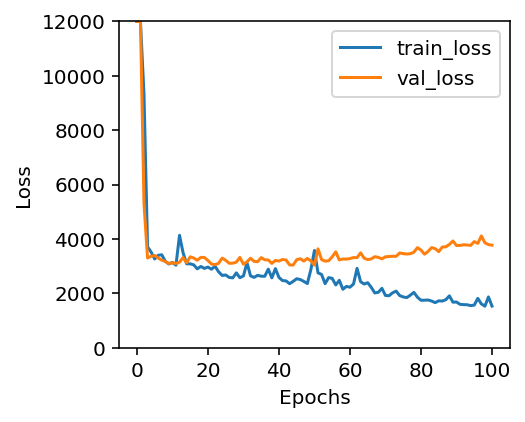

In [69]:
ncols = X.shape[1]
n_neurons = 1000
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.Tanh(),
    nn.Linear(n_neurons, 1)
)

history, best_model = sgdtrain(model, X_train, X_test, y_train, y_test,
                               learning_rate=.01, nepochs=100, batch_size=32)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))

Epoch    0 MSE train loss     5963.577   test loss     4329.519
Epoch   10 MSE train loss     2944.833   test loss     4627.387
Epoch   20 MSE train loss     1739.439   test loss     5615.343
Epoch   30 MSE train loss     1950.074   test loss     5060.556
Epoch   40 MSE train loss     1816.964   test loss     5330.397
Epoch   50 MSE train loss     1834.356   test loss     5960.328
Epoch   60 MSE train loss     1708.260   test loss     4621.075
Epoch   70 MSE train loss     1016.757   test loss     4534.361
Epoch   80 MSE train loss     1071.208   test loss     5348.936
Epoch   90 MSE train loss     1241.025   test loss     6891.121
Epoch  100 MSE train loss     1158.777   test loss     5605.638
BEST MSE test loss 3865.053
Epoch    0 MSE train loss    10518.783   test loss     4235.327
Epoch   10 MSE train loss     2300.827   test loss     3718.561
Epoch   20 MSE train loss      900.684   test loss     4221.584
Epoch   30 MSE train loss      529.093   test loss     4681.926
Epoch   40 M

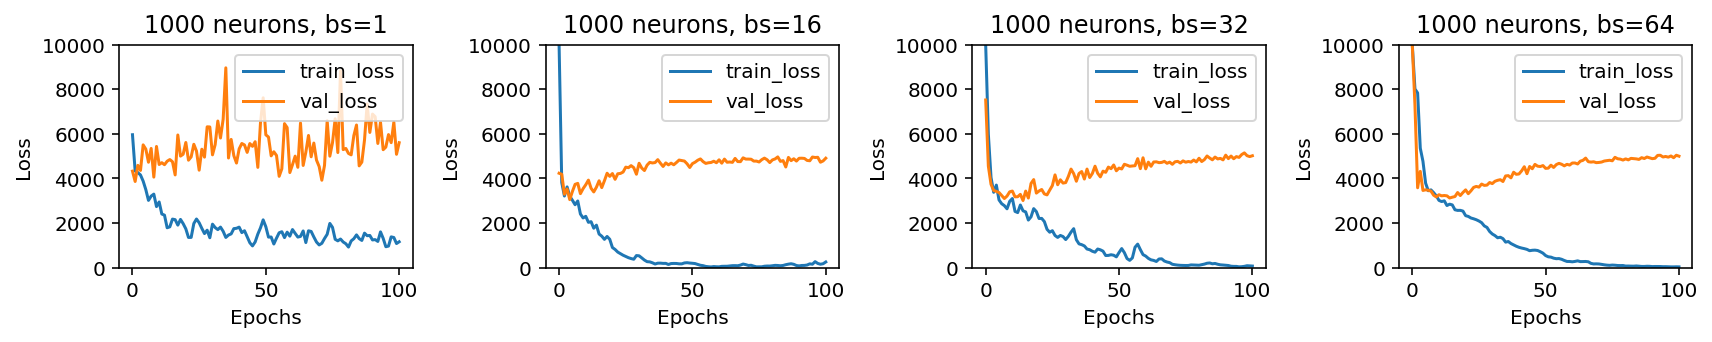

In [70]:
fig, axes = plt.subplots(1, 4,figsize=(12,2.5))

for bs,ax in zip([1,16,32,64],axes):
    model = nn.Sequential(
        nn.Linear(ncols, n_neurons),
        nn.Tanh(),
        nn.Linear(n_neurons, 1)
    )
    history, best_model = sgdtrain(model, X_train, X_test, y_train, y_test,
                                   learning_rate=.05, nepochs=100, batch_size=bs,
                                   trace=True)
    ax.set_title(f"{n_neurons} neurons, bs={bs}")
    plot_history(torch.clamp(history, 0, 10000), ax=ax, maxy=10_000)

plt.tight_layout()
plt.show()